In [2]:
import pybamm as pb;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
import scipy.optimize
import random;import time, signal
from matplotlib import gridspec
fs=10;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

In [ ]:
# load model
model_ORegan2022 = pb.lithium_ion.DFN()

# create geometry
geometry = model_ORegan2022.default_geometry

# load parameter values and process model and geometry
param = pb.ParameterValues("ORegan2022")

In [4]:
#GITT Experiment text
V_max = 4.2;        V_min = 2.5
exp_topup_text = [ (
    f"Discharge at 0.5C until {V_max-0.2}V", # start from discharge as it is easier for unbalanced cells
    f"Charge at 0.3C until {V_max}V",
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours", 
    ) ] 
exp_GITT_text = [ (
    "Rest for 60 seconds (1 second period)", 
    "Discharge at 1C for 144 seconds or until 2.5V (0.1 second period)", 
    "Rest for 1 hour (1 second period)"
    ) ]

experiment = pb.Experiment( 
    exp_topup_text * 1 + exp_GITT_text * 25 ) 

var_pts = {
    "x_n": 5,  # negative electrode
    "x_s": 5,  # separator 
    "x_p": 5,  # positive electrode
    "r_n": 80,  # negative particle
    "r_p": 20,  # positive particle
}


In [5]:
# run pybamm model
sim = pb.Simulation(
    model=model_ORegan2022, 
    experiment = experiment,
    parameter_values=param,
    solver=model_ORegan2022.default_solver,
    var_pts=var_pts, )
sol = sim.solve(calc_esoh=False,)

C:\Users\frw21\AppData\Local\Temp\ipykernel_8852\2800267796.py:6: UserWarning: The default solver changed to IDAKLUSolver after the v25.4.0. release. You can swap back to the previous default by using `pybamm.CasadiSolver()` instead.
  solver=model_ORegan2022.default_solver,


Supplementary Figure 14(b) saved to C:\Users\frw21\Desktop\ESE_UROP_2025\Project_Files\Model_testing\Figures\\GITT_1C_FULL.png


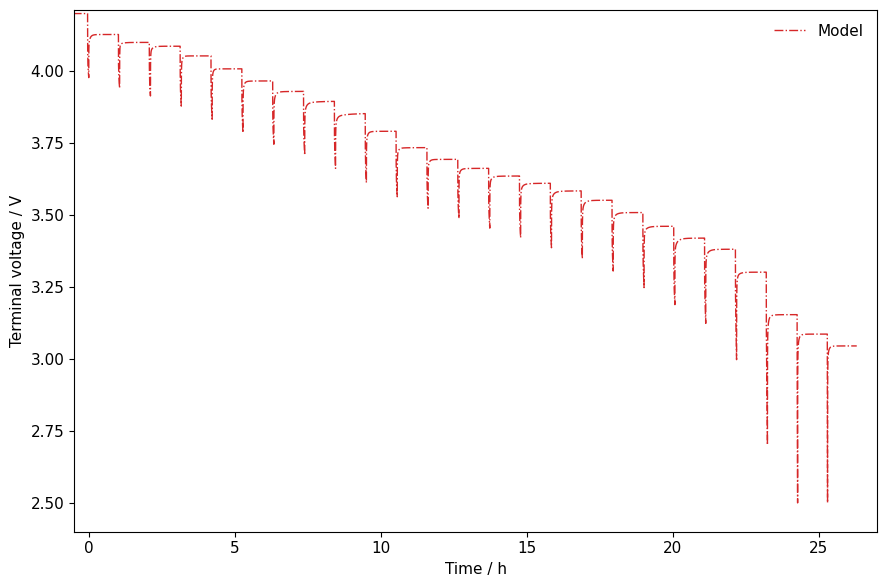

In [10]:
def Plot_Comp_GITT_Overall(sol, Save_Fig, fig_name):
    # Plot setting
    font = {'family' : 'DejaVu Sans', 'size' : 11}
    mpl.rc('font', **font)
    lw=1
    Colors = ['#1f77b4','#2ca02c',  '#d62728', '#ff7f0e']
    # sol = DD_Dis_All[0]
    t_seconds = sol["Time [s]"].entries
    t_sim_start = sol.cycles[1].steps[2]["Time [s]"].entries[0]  # shift
    t_hours = (t_seconds - t_sim_start) / 3600
    I = sol["Current [A]"].entries
    Q = sol["Discharge capacity [A.h]"].entries
    V = sol["Terminal voltage [V]"].entries

    fig, ax = plt.subplots(figsize=(9,6),tight_layout=True)
    dict_fig_i_ax={}

    ax.plot(
        t_hours,V,color=Colors[2],linewidth=lw,    
        linestyle='-.',label='Model')
    dict_fig_i_ax['Time_h_Model'] = t_hours
    dict_fig_i_ax['Voltage_V_Model'] = V
    df_fig_i_ax = pd.DataFrame.from_dict(dict_fig_i_ax, orient='index').T

    ax.set_xlabel('Time / h')
    ax.set_ylabel('Terminal voltage / V')
    plt.xlim(-0.5,27)
    plt.ylim(2.4,4.21)
    #ax.set_title('25x1C pulses at 298K, comparison')
    ax.legend(loc='best',frameon=False)

    if Save_Fig:
        Save_path = r'C:\Users\frw21\Desktop\ESE_UROP_2025\Project_Files\Model_testing\Figures\\' + fig_name

        plt.savefig(Save_path, dpi=600)
        print(f"Supplementary Figure 14(b) saved to {Save_path}")

    plt.show()

    return 

Save_Fig = True; 
Plot_Comp_GITT_Overall(
    sol, Save_Fig, fig_name = "GITT_1C_FULL.png"
) 

Supplementary Figure 14(b) saved to C:\Users\frw21\Desktop\ESE_UROP_2025\Project_Files\Model_testing\Figures\\GITT_1C_ZOOMED_POS_NEG.png


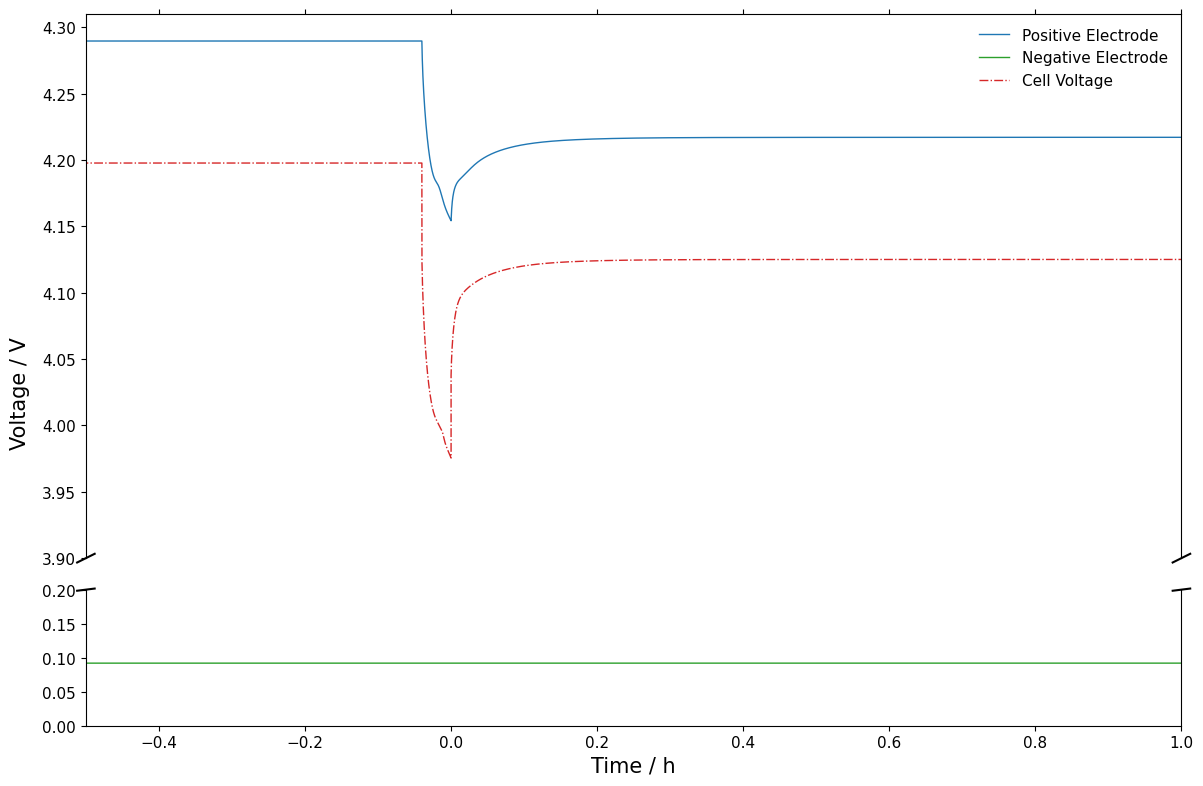

In [12]:
from matplotlib import ticker

def Plot_Pos_Neg_Electrode_Voltages_GITT(sol, filename=None, savefig=False):
    font = {'family' : 'DejaVu Sans', 'size' : 11}
    mpl.rc('font', **font)
    lw = 1
    Colors = ['#1f77b4', '#2ca02c', '#d62728', '#ff7f0e']

    t_seconds = sol["Time [s]"].entries
    t_sim_start = sol.cycles[1].steps[2]["Time [s]"].entries[0]
    t_hours = (t_seconds - t_sim_start) / 3600

    OCP_PE = sol["Positive electrode open-circuit potential [V]"]
    OCP_NE = sol["Negative electrode open-circuit potential [V]"]
    V_cell = sol["Terminal voltage [V]"].entries

    # Create a gridspec for custom subplot layout: 1 row on top, 2 beloW
    fig = plt.figure(figsize=(12, 8))

    # Create two subplots with shared x-axis
    ax_high, ax_low = fig.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [4, 1]})

    # Plot on both axes
    ax_high.plot(t_hours, OCP_PE(t=t_seconds)[0], color=Colors[0], linewidth=lw, label='Positive Electrode')
    ax_high.plot(t_hours, OCP_NE(t=t_seconds)[0], color=Colors[1], linewidth=lw, label='Negative Electrode')
    ax_high.plot(t_hours, V_cell, color=Colors[2], linewidth=lw, linestyle='-.', label='Cell Voltage')

    ax_low.plot(t_hours, OCP_PE(t=t_seconds)[0], color=Colors[0], linewidth=lw)
    ax_low.plot(t_hours, OCP_NE(t=t_seconds)[0], color=Colors[1], linewidth=lw)
    ax_low.plot(t_hours, V_cell, color=Colors[2], linewidth=lw, linestyle='-.')

    # Set y-limits
    ax_high.set_ylim(3.9, 4.31)
    ax_low.set_ylim(0, 0.2)

    # Hide the spines between ax_high and ax_low
    ax_high.spines['bottom'].set_visible(False)
    ax_low.spines['top'].set_visible(False)
    ax_high.xaxis.tick_top()
    ax_high.tick_params(labeltop=False)  # don't put tick labels at the top
    ax_low.xaxis.tick_bottom()

    # Diagonal lines to indicate the break
    d = .008  # size of diagonal lines
    kwargs = dict(transform=ax_high.transAxes, color='k', clip_on=False)
    ax_high.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax_high.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax_low.transAxes)  # switch to the bottom axes
    ax_low.plot((-d, +d), (1 - d, 1 + d), **kwargs)   # bottom-left diagonal
    ax_low.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    # Set labels
    ax_low.set_xlabel('Time / h', fontsize=15)
    ax_low.set_ylabel(' ', fontsize=15)
    fig.text(0, 0.5, 'Voltage / V', va='center', rotation='vertical', fontsize=15)

    ax_high.set_xlim(-0.5, 1)
    ax_low.set_xlim(-0.5, 1)

    ax_high.legend(loc='best', frameon=False)
    plt.tight_layout()

    if Save_Fig:
        Save_path = r'C:\Users\frw21\Desktop\ESE_UROP_2025\Project_Files\Model_testing\Figures\\' + filename

    plt.savefig(Save_path, dpi=600)
    print(f"Supplementary Figure 14(b) saved to {Save_path}")

    plt.show
    return



Plot_Pos_Neg_Electrode_Voltages_GITT(sol, savefig=True, filename='GITT_1C_ZOOMED_POS_NEG.png')

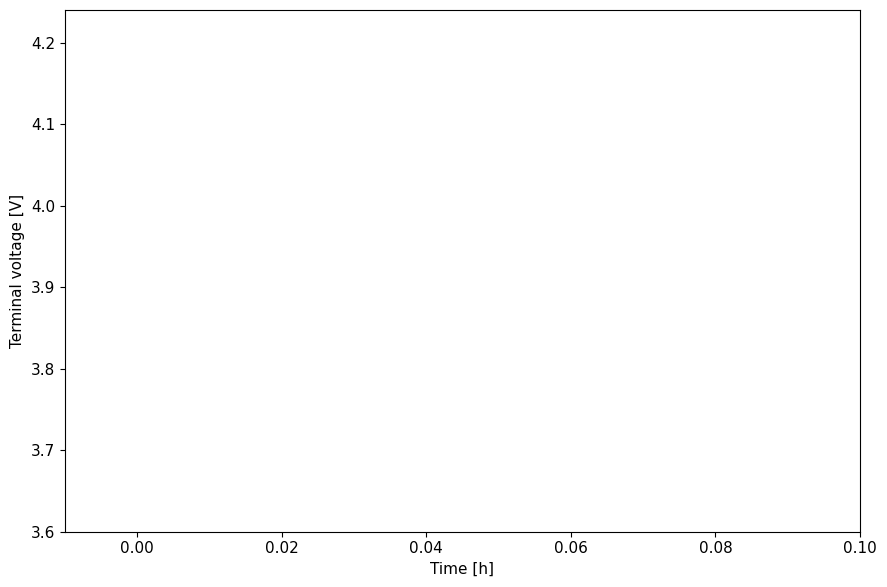

In [13]:
# zoom in:
lw = 1
def Plot_compare_zoom ( sol, Xlim, Ylim):
    Colors = ['#1f77b4','#2ca02c',  '#d62728', '#ff7f0e'];
    t_seconds = sol["Time [s]"].entries
    # shift the modelling time to t=0 to be first discharge
    t_sim_start = sol.cycles[1].steps[1]["Time [s]"].entries[0] 
    t_hours = (t_seconds - t_sim_start) / 3600
    I = sol["Current [A]"].entries
    Q = sol["Discharge capacity [A.h]"].entries
    V = sol["Terminal voltage [V]"].entries

    fig, ax = plt.subplots(figsize=(9,6),tight_layout=True)

    ax.set_xlabel('Time [h]')
    ax.set_ylabel('Terminal voltage [V]')
    # plt.xlim(-0.5,27)
    # plt.ylim(2.4,4.21)
    plt.xlim(Xlim)
    plt.ylim(Ylim)
    #ax.set_title('25x1C pulses at 298K, comparison')
    #ax.legend(loc='best',frameon=False)
    return 
Xlim=(-0.01,0.1)  
Ylim = (3.6,4.24)
k=1

Plot_compare_zoom ( sol, Xlim, Ylim)